In [213]:
function projection(x)
    n = length(x)
    s = x[end]
    v = view(x,1:n-1)
    a = norm(v)
    if a <= -s  # below the cone
        return zero(x)
    elseif a <= s  # in the code
        return x
    elseif a >= abs(s)  # outside the cone
        return 0.5 * (1 + s/a) * [v; a] 
    end
end
function ∇projection(x)
    n = length(x)
    J = zeros(eltype(x),n,n)
    s = x[end]
    v = view(x,1:n-1)
    a = norm(v)
    if a <= -s
        return J  # zeros
    elseif a <= s
        J .= I(n)  
        return J  # identity
    elseif a >= abs(s)
        c = 0.5 * (1 + s/a)

        # dvdv ok!
        for i = 1:n-1, j = 1:n-1
            J[i,j] = -0.5*s/a^3 * v[i] * v[j]
            if i == j
                J[i,j] += c
            end
        end

        # dvds ok!
        for i = 1:n-1
            J[i,n] = 0.5 * v[i] / a
        end

        # dsdv ok!
        for i = 1:n-1
            J[n,i] = ((-0.5*s/a^2) + c/a) * v[i]
        end
        J[n,n] = 0.5  # ok
        return J
    else
        error("Invalid second-order cone projection.")
    end
    return J
end
function ∇²projection(x, b)
    # x is lamda_bar, b is projection(lambda_bar)
    n = length(x)
    hess = zeros(eltype(x),n,n)
    v = view(x, 1:n-1)
    bv = view(b, 1:n-1)

    # @assert size(hess) == (n+1,n+1)
    s = x[end]
    bs = b[end]
    a =  norm(v)
    vbv = dot(v,bv)

    if a <= -s
        return hess .= 0
    elseif a <= s
        return hess .= 0
    elseif a > abs(s)
        # Original equations from chain rule
        # dvdv = -s/norm(v)^2/norm(v)*(I - (v*v')/(v'v))*bv*v' + 
        #     s/norm(v)*((v*(v'bv))/(v'v)^2 * 2v' - (I*(v'bv) + v*bv')/(v'v)) + 
        #     bs/norm(v)*(I - (v*v')/(v'v))
        # dvds = 1/norm(v)*(I - (v*v')/(v'v))*bv;
        # # display(dvds)
        # # display(dvdv)
        # hess[1:n-1,1:n-1] .= dvdv*0.5
        # hess[1:n-1,n] .= dvds*0.5
        # hess[n:n,1:n-1] .= 0.5*dvds'
        # hess[n,n] = 0
        # return hess

        # The following is just an unrolled version of the above
        n = n - 1
        dvdv = view(hess, 1:n, 1:n)
        dvds = view(hess, 1:n, n+1)
        dsdv = view(hess, n+1, 1:n)
        @inbounds for i = 1:n
            hi = 0
            @inbounds for j = 1:n
                Hij = -v[i]*v[j] / a^2
                if i == j
                    Hij += 1
                end
                hi += Hij * bv[j]
            end
            dvds[i] = hi / 2a
            dsdv[i] = dvds[i]
            @inbounds for j = 1:i
                vij = v[i] * v[j]
                H1 = hi * v[j] * (-s/a^3)
                H2 = vij * (2*vbv) / a^4 - v[i] * bv[j] / a^2
                H3 = -vij / a^2
                if i == j
                    H2 -= vbv / a^2
                    H3 += 1
                end
                H2 *= s/a
                H3 *= bs/a
                dvdv[i,j] = (H1 + H2 + H3) / 2
                dvdv[j,i] = dvdv[i,j]
            end
        end
        hess[end,end] = 0
        return hess
    else
        throw(ErrorException("Invalid second-order cone projection"))
    end
end
function conic_cost(λ, ρ, x)
    c = cone_u(params, x)
    λhat = λ + ρ*c
    return 0.5*norm(projection(λhat))^2/ρ
end
function conic_cost_expansion(p::NamedTuple, u, λ, ρ, k)
    c = cone_u(params, x)
    λhat = λ + ρ*c
    ∇c = cone_u_jac(p, u)
    G = ∇c'*∇projection(λhat)*projection(λhat)
    # H = ∇c'*∇projection(λhat)'*∇projection(λhat)*∇c*ρ
    H = ∇c'*(∇projection(λhat)'*∇projection(λhat) + 
        ∇²projection(λhat, projection(λhat)))*∇c*ρ
    return G, H
end
λ = rand(3)*100
ρ = 1e4
x = rand(3)*100

# G = FiniteDiff.finite_difference_jacobian(_x->conic_cost(λ, ρ, _x),x)
# H = FiniteDiff.finite_difference_hessian(_x->conic_cost(λ, ρ, _x),x)
G = ForwardDiff.gradient(_x->conic_cost(λ, ρ, _x),x)
H = ForwardDiff.hessian(_x->conic_cost(λ, ρ, _x),x)
G1, H1 = conic_cost_expansion(params, x, λ, ρ, 1)
print("Norm gradient difference: ", norm(G1-G))
print("\nNorm Hessian difference: ", norm(H1-H))
x1 = x+rand(3)*1
error1 = conic_cost(λ, ρ, x1) - conic_cost(λ, ρ, x) - G'*(x1-x) - 0.5*(x1-x)'*H*(x1-x)
error2 = FiniteDiff.finite_difference_jacobian(_x->conic_cost(λ, ρ, _x),x1) - G' - (x1-x)'*H
print("\nValue error: ", error1)
print("\nDiff Value error: ", error2)
# display(eigvals(H1))
# display(eigvals(H))
# display(G')
# display(G1)
# display(H1)
# display(G1+H1*x)
# H1*x

Norm gradient difference: 0.0
Norm Hessian difference: 8.898537205626138e-13
Value error: 0.002430646380162216
Diff Value error: [0.0650101123683271 -0.07490947916994628 0.00017858418794958197]

In [214]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using LinearAlgebra
using Random
using FiniteDiff
using ForwardDiff
using Printf

  Activating environment at `~/SSD/Code/TinyMPC/julia/cone_simple/Project.toml`


In [233]:
# -------------------THIS IS ALL ALTRO-------------------------------
# This enables goal equality constraints, state and input ineq constraints.
function stage_cost(p::NamedTuple,x,u,k)
    dx = x - p.Xref[k]
    du = u - p.Uref[k]
    return 0.5*dx'*p.Q*dx + 0.5*du'*p.R*du
end
function term_cost(p::NamedTuple,x)
    dx = x - p.Xref[p.N]
    return 0.5*dx'*p.Qf*dx
end
function stage_cost_expansion(p::NamedTuple,k)
    dx = - p.Xref[k]
    du = - p.Uref[k]
    return p.Q, p.Q*dx, p.R, p.R*du  # Hessian and gradient
end
function term_cost_expansion(p::NamedTuple)
    dx = - p.Xref[p.N]
    return p.Qf, p.Qf*dx
end
function conic_cost_expansion(p::NamedTuple, u, λc, ρ, k)
    λhat = λc # already updated
    ∇c = cone_u_jac(p, u)
    G = -∇c'*∇projection(λhat)*projection(λhat)
    # H = ∇c'*∇projection(λhat)'*∇projection(λhat)*∇c*ρ
    H = ∇c'*(∇projection(λhat)'*∇projection(λhat) + ∇²projection(λhat, projection(λhat)))*∇c*ρ
    return (G - H*u*0), H
end
function backward_pass!(params,X,U,P,p,d,K,reg,μ,μx,ρ,λ,λc)
    """iLQR backward pass with AL. This !function update its parameters
    """
    N = params.N
    ΔJ = 0.0    # expected cost reduction

    # terminal cost expansion
    P[N], p[N] = term_cost_expansion(params) 
    
    if (params.ncx > 0)
        # # add AL terms for the state constraint at the final time step
        hxv = ineq_con_x(params,X[N])  # h(x) violation  
        mask = eval_mask(μx[N],hxv)
        ∇hx = ineq_con_x_jac(params,X[N])
        # add these into the cost-to-go p and P
        p[N]  += ∇hx'*(μx[N] - ρ*(mask * [params.x_max;-params.x_min]))  # multiplier term (1st)
        P[N]  += ρ*∇hx'*mask*∇hx                # penalty term (2nd)
    end
    
    if (params.ncg > 0)
        # add AL terms for goal constraint 
        ∇hx = diagm(ones(params.nx))
        # add these into the CTG p and P (equality active)
        p[N]  += ∇hx'*(λ - ρ*params.Xref[N])   
        P[N]  += ρ*∇hx'∇hx
    end
    
    # iterate from N-1 to 1 backwards
    for k = (N-1):(-1):1
        # dynamics jacobians (linearization about previous iterate)
        A = ForwardDiff.jacobian(_x -> discrete_dynamics(params,_x,U[k],k),X[k])
        B = ForwardDiff.jacobian(_u -> discrete_dynamics(params,X[k],_u,k),U[k])

        Sxx,Sx,Suu,Su = stage_cost_expansion(params,k)
        
        # one-step cost expansion: Q, Q*dx, R, R*du
        Sx += A' * (P[k+1]*f + p[k+1]) 
        Su += B' * (P[k+1]*f + p[k+1]) 
        Sxx += A'*(P[k+1])*A
        Suu += B'*(P[k+1] + reg*I)*B                                     
        Sux = B'*(P[k+1])*A  
        if (params.ncu > 0)
            # control constraints
            huv = ineq_con_u(params,U[k])  # calculate h(u) constraint
            mask = eval_mask(μ[k],huv)  # choose active
            ∇hu = ineq_con_u_jac(params,U[k])
            Su  += ∇hu'*(μ[k] - ρ*(mask * [params.u_max;-params.u_min])) # add to cost
            Suu += ρ*∇hu'*mask*∇hu
        end
        if (params.ncx > 0)
            # state constraints
            hxv = ineq_con_x(params,X[k])
            mask = eval_mask(μx[k],hxv)
            ∇hx = ineq_con_x_jac(params,X[k])
            Sx  += ∇hx'*(μx[k] - ρ*(mask * [params.x_max;-params.x_min]))
            Sxx += ρ*∇hx'*mask*∇hx
        end
        if (params.ncu_cone > 0)
            # conic constraints
            Qu, Quu = conic_cost_expansion(params, U[k], λc[k], ρ*cone_scale, k)
            # display(Quu)
            Su += Qu
            Suu += Quu
        end
        
        # Calculate Gains
        # if isposdef(Suu) == 0
        #     for i = 1:10
        #         Suu += reg*I
        #         if isposdef(Suu) == 1
        #             break
        #         end
        #     end
        # end
            
        F = cholesky(Symmetric(Suu))
        d[k] = F\Su
        K[k] = F\Sux

        # Cost-to-go Recurrence (PSD stabilizing version, last term)
        P[k] = Sxx + K[k]'*Suu*K[k] - 2*K[k]'*Sux
        p[k] = Sx + K[k]'*Suu*d[k] - K[k]'*Su - Sux'*d[k]
        ΔJ += Su'*d[k]
    end

    return ΔJ  # but also change params
end
function forward_pass!(params,X,U,K,d,ΔJ,Xn,Un,μ,μx,ρ,λ; 
                        max_linesearch_iters = 20)
    """iLQR forward pass and line-search
    This !function update its parameters
    """
    N = params.N
        # Forward Rollout
        for k = 1:(N-1)
            Un[k] = - d[k] - K[k]*Xn[k] 
            Xn[k+1] = discrete_dynamics(params,Xn[k],Un[k],k)
        end
    X .= Xn
    U .= Un
    return 0, 0
end
function eval_mask(μv,huv)  
    # Extract active inequality constraints
    # active set mask
    mask = Diagonal(zeros(length(huv)))
    for i = 1:length(huv)
        mask[i,i] = (μv[i] > 0 || huv[i] > 0)
    end
    mask
end
function mpc(params,X,U,P,p,K,d,Xn,Un;atol=1e-4,max_iters = 20,verbose = true,ρ=1,ρ_max = 1e8,ϕ=10)

    # first check the sizes of everything
    # @assert length(X) == params.N
    # @assert length(U) == params.N-1
    # @assert length(X[1]) == params.nx
    # @assert length(U[1]) == params.nu

    # initial rollout
    N = params.N
    for i = 1:N-1
        X[i+1] = discrete_dynamics(params,X[i],U[i],i)
    end

    reg_min = 1e-8
    reg = reg_min

    μ = [zeros(params.ncu) for i = 1:N-1]   # input constraints

    μx = [zeros(params.ncx) for i = 1:N]    # state constraints

    λ = zeros(params.nx)    # goal constraint

    λc = [zeros(params.ncu_cone) for i = 1:N-1]   # goal constraint
    
    # Inner loop to solve unconstrained problem (Riccati)
    for iter = 1:max_iters
        
        J = 0.0
        ΔJ = 0.0
        α = 1.0
        for i = 1:1
            ΔJ = backward_pass!(params,X,U,P,p,d,K,reg,μ,μx,ρ,λ,λc)
            J, α = forward_pass!(params,X,U,K,d,ΔJ,Xn,Un,μ,μx,ρ,λ)
        end

        if verbose
            if rem(iter-1,10)==0
                @printf "iter     J           ΔJ        |d|         α        reg         ρ\n"
                @printf "---------------------------------------------------------------------\n"
            end
            @printf("%3d   %10.3e  %9.2e  %9.2e  %6.4f   %9.2e   %9.2e\n",
              iter, J, ΔJ, 0, α, reg, ρ)
        end
        # update multipliers and check constraint violation, max of all
        convio = 0  
        
        if (params.ncu > 0)
            # control constraints (inequality)
            for k = 1:N-1
                huv = ineq_con_u(params,U[k])
                mask = eval_mask(μ[k],huv)
                # update dual
                convio = max(convio,norm(huv + abs.(huv),Inf))
                μ[k] = max.(0,μ[k] - ρ*(mask * [params.u_max;-params.u_min]))
            end
        end
        if (params.ncx > 0)
            # state constraints (inequality)
            for k = 1:N
                hxv = ineq_con_x(params,X[k])
                mask = eval_mask(μx[k],hxv)
                # update dual
                convio = max(convio,norm(hxv + abs.(hxv),Inf))
                μx[k] = max.(0,μx[k] - ρ*(mask * [params.x_max;-params.x_min]))                
            end
        end
        if (params.ncu_cone > 0)
            # conic constraints 
            if verbose
                print("update cone\n")
            end            
            for k = 1:N-1
                # update dual
                Uc = cone_u(params, U[k])
                huc = norm(Uc[1:2]) - Uc[3]
                convio = max(convio, norm(huc + abs.(huc),Inf))
                λc[k] = projection(λc[k] - Uc*cone_scale*ρ)
                # display(λc[k])
            end
        end
        if (params.ncg > 0)
            # goal constraint (equality)
            hxv = X[N] - params.Xref[N]
            λ .-= ρ*params.Xref[N]
            convio = max(convio, norm(hxv,Inf))
        end
        
        ρ *= ϕ  # update penalty
        
        if verbose
            @show convio
        end
        if convio < atol  # if terminal condition with contraint violation
            # print("Our solver says SUCCESS\n") # @info "success!"
            return U[1]
        end
        if ρ > ρ_max
            print("Our solver reachs MAX PENALTY\n")
            return U[1]
        end
    end
    print("Our solver says INFEASIBLE and MAX ITER\n")
    return U[1]
end
#----------------------ALTRO DONE --------------------------

mpc (generic function with 1 method)

In [234]:
# =============================
# Example problem formulation and solve
# =============================

# ---------------------THIS IS WHAT YOU NEED TO INPUT--------
A = [1.0 0.0 0.0 0.05 0.0 0.0; 
    0.0 1.0 0.0 0.0 0.05 0.0; 
    0.0 0.0 1.0 0.0 0.0 0.05; 
    0.0 0.0 0.0 1.0 0.0 0.0; 
    0.0 0.0 0.0 0.0 1.0 0.0; 
    0.0 0.0 0.0 0.0 0.0 1.0]
B = [0.000125 0.0 0.0; 
    0.0 0.000125 0.0;
    0.0 0.0 0.000125; 
    0.005 0.0 0.0; 
    0.0 0.005 0.0; 
    0.0 0.0 0.005]
f = [0.0, 0.0, -0.0122625, 0.0, 0.0, -0.4905]
function discrete_dynamics(p::NamedTuple,x,u,k)
    A = [1.0 0.0 0.0 0.05 0.0 0.0; 
        0.0 1.0 0.0 0.0 0.05 0.0; 
        0.0 0.0 1.0 0.0 0.0 0.05; 
        0.0 0.0 0.0 1.0 0.0 0.0; 
        0.0 0.0 0.0 0.0 1.0 0.0; 
        0.0 0.0 0.0 0.0 0.0 1.0]
    B = [0.000125 0.0 0.0; 
        0.0 0.000125 0.0;
        0.0 0.0 0.000125; 
        0.005 0.0 0.0; 
        0.0 0.005 0.0; 
        0.0 0.0 0.005]
    f = [0.0, 0.0, -0.0122625, 0.0, 0.0, -0.4905]
    return A*x + B*u + f
end
function ineq_con_x(p,x)
    [x-p.x_max;-x + p.x_min]
end
function ineq_con_u(p,u)
    [u-p.u_max;-u + p.u_min]
end
function cone_u(p, u)
    [p.A_cone*u;p.c_cone'*u]
end
function cone_u_jac(p, u)
    J = zeros(p.nu, p.nu)
    J[1:end-1,1:end] .= p.A_cone
    J[end,1:end] .= p.c_cone
    return J
end
function ineq_con_u_jac(params,u)
    ForwardDiff.jacobian(_u -> ineq_con_u(params,_u), u)
end
function ineq_con_x_jac(p,x)
    ForwardDiff.jacobian(_x -> ineq_con_x(p,_x),x)
end
function projection(x)
    n = length(x)
    s = x[end]
    v = view(x,1:n-1)
    a = norm(v)
    if a <= -s  # below the cone
        return zero(x)
    elseif a <= s  # in the code
        return x
    elseif a >= abs(s)  # outside the cone
        return 0.5 * (1 + s/a) * [v; a] 
    end
end
function ∇projection(x)
    n = length(x)
    J = zeros(eltype(x),n,n)
    s = x[end]
    v = view(x,1:n-1)
    a = norm(v)
    if a <= -s
        return J  # zeros
    elseif a <= s
        J .= I(n)  
        return J  # identity
    elseif a >= abs(s)
        c = 0.5 * (1 + s/a)

        # dvdv ok!
        for i = 1:n-1, j = 1:n-1
            J[i,j] = -0.5*s/a^3 * v[i] * v[j]
            if i == j
                J[i,j] += c
            end
        end

        # dvds ok!
        for i = 1:n-1
            J[i,n] = 0.5 * v[i] / a
        end

        # dsdv ok!
        for i = 1:n-1
            J[n,i] = ((-0.5*s/a^2) + c/a) * v[i]
        end
        J[n,n] = 0.5  # ok
        return J
    else
        error("Invalid second-order cone projection.")
    end
    return J
end
function ∇²projection(x, b)
    # x is lamda_bar, b is projection(lambda_bar)
    n = length(x)
    hess = zeros(eltype(x),n,n)
    v = view(x, 1:n-1)
    bv = view(b, 1:n-1)

    # @assert size(hess) == (n+1,n+1)
    s = x[end]
    bs = b[end]
    a =  norm(v)
    vbv = dot(v,bv)

    if a <= -s
        return hess .= 0
    elseif a <= s
        return hess .= 0
    elseif a > abs(s)
        # Original equations from chain rule
        # dvdv = -s/norm(v)^2/norm(v)*(I - (v*v')/(v'v))*bv*v' + 
        #     s/norm(v)*((v*(v'bv))/(v'v)^2 * 2v' - (I*(v'bv) + v*bv')/(v'v)) + 
        #     bs/norm(v)*(I - (v*v')/(v'v))
        # dvds = 1/norm(v)*(I - (v*v')/(v'v))*bv;
        # # display(dvds)
        # # display(dvdv)
        # hess[1:n-1,1:n-1] .= dvdv*0.5
        # hess[1:n-1,n] .= dvds*0.5
        # hess[n:n,1:n-1] .= 0.5*dvds'
        # hess[n,n] = 0
        # return hess

        # The following is just an unrolled version of the above
        n = n - 1
        dvdv = view(hess, 1:n, 1:n)
        dvds = view(hess, 1:n, n+1)
        dsdv = view(hess, n+1, 1:n)
        @inbounds for i = 1:n
            hi = 0
            @inbounds for j = 1:n
                Hij = -v[i]*v[j] / a^2
                if i == j
                    Hij += 1
                end
                hi += Hij * bv[j]
            end
            dvds[i] = hi / 2a
            dsdv[i] = dvds[i]
            @inbounds for j = 1:i
                vij = v[i] * v[j]
                H1 = hi * v[j] * (-s/a^3)
                H2 = vij * (2*vbv) / a^4 - v[i] * bv[j] / a^2
                H3 = -vij / a^2
                if i == j
                    H2 -= vbv / a^2
                    H3 += 1
                end
                H2 *= s/a
                H3 *= bs/a
                dvdv[i,j] = (H1 + H2 + H3) / 2
                dvdv[j,i] = dvdv[i,j]
            end
        end
        hess[end,end] = 0
        return hess
    else
        throw(ErrorException("Invalid second-order cone projection"))
    end
end

∇²projection (generic function with 1 method)

iter     J           ΔJ        |d|         α        reg         ρ
---------------------------------------------------------------------
  1    0.000e+00   3.56e+06   0.00e+00  0.0000    1.00e-08    1.00e+00
update cone
convio = 29.899759669898994
  2    0.000e+00   3.60e+06   0.00e+00  0.0000    1.00e-08    1.00e+01
update cone
convio = 29.3319637774497
  3    0.000e+00   3.82e+06   0.00e+00  0.0000    1.00e-08    1.00e+02
update cone
convio = 25.16204518205809
  4    0.000e+00   3.74e+06   0.00e+00  0.0000    1.00e-08    1.00e+03
update cone
convio = 11.43586560822942
  5    0.000e+00   3.19e+06   0.00e+00  0.0000    1.00e-08    1.00e+04
update cone
convio = 1.8073307857280299
  6    0.000e+00   3.06e+06   0.00e+00  0.0000    1.00e-08    1.00e+05
update cone
convio = 0.6230915406263442
  7    0.000e+00   3.25e+06   0.00e+00  0.0000    1.00e-08    1.00e+06
update cone
convio = 1.5491365719587087
  8    0.000e+00   5.46e+06   0.00e+00  0.0000    1.00e-08    1.00e+07
update cone
convio =

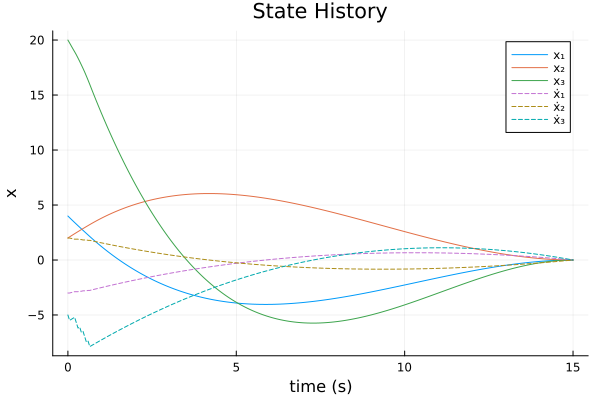

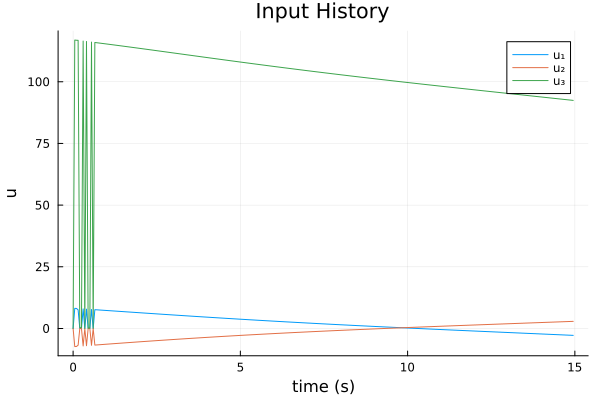

In [248]:
# @changeprecision Float32 begin
# Let's solve

# λ = zeros(params.nx)    # goal constraint
# λc = [zeros(params.ncu_cone) for i = 1:N-1]   # goal constraint
    
# Let's solve

nx = 6
nu = 3
N = 301
dt = 0.05
t_vec = dt*(0:N-1)
x0 = [4, 2, 20, -3, 2, -5.0]
xg = [0,0,0,0,0,0.0]
Xref = [deepcopy(xg) for i = 1:N]
Uref = [zeros(nu) for i = 1:N-1]

Q = 1e-1*I(nx)
R = 10e-1*I(nu)
Qf = 100*I(nx)

# ground_level = 0.0
gravity = [0; 0; -9.81]
mass = 10.0
# ωPlanet = [0.0; 0.0; 0.0]
perWeightMax = 2.0
θ_thrust_max = 5.0  # deg
# θ_glideslope = 60.0 # deg
# glide_recover_k = 8

A_cone = [1 0 0; 0 1 0]
c_cone = [0.0, 0.0, tand(θ_thrust_max)]
u_bnd = mass * abs(gravity[3]) * perWeightMax
u_min = -170*ones(nu)
u_max =  170*ones(nu)

# state is x y v θ
x_min = [-5,-5,0,-10,-10,-10.0]
x_max = [5,5,20,10,10,10.0]

ncx = 2*nx*0
ncu = 2*nu*0
ncg = 1
ncu_cone = nu*1; 
cone_scale = 1e-2  # very fragile for each problem

params = (
    nx = nx,
    nu = nu,
    ncx = ncx,
    ncu = ncu,
    ncg = ncg,
    ncu_cone = ncu_cone,
    A_cone = A_cone,
    c_cone = c_cone,
    N = N,
    Q = Q,
    R = R,
    Qf = Qf,
    u_min = u_min,
    u_max = u_max,
    x_min = x_min,
    x_max = x_max,
    Xref = Xref,
    Uref = Uref,
    dt = dt,
    mc = 1.0,
    mp = 0.2,
    l = 0.5,
    g = 9.81,
);

# previous iterate
X = [deepcopy(x0) for i = 1:N]
U = [zeros(nu) for k = 1:N-1]
# X = Xref*1
# U = Uref*1
# new iterate
Xn = deepcopy(X)
Un = deepcopy(U)

P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
p = [zeros(nx) for i = 1:N]      # cost to go linear term
d = [zeros(nu) for i = 1:N-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:N-1] # feedback gain
u_ = mpc(params,X,U,P,p,K,d,Xn,Un; atol=1e-4, max_iters = 20, verbose = true, ρ = 1e0, ρ_max = 1e8, ϕ = 10.0);
function mat_from_vec(X)::Matrix
    # convert a vector of vectors to a matrix 
    Xm = hcat(X...)
    return Xm 
end
Xsim_m = mat_from_vec(Xn)
Usim_m = mat_from_vec(Un)
using Plots
display(plot(t_vec,Xsim_m',label = ["x₁" "x₂" "x₃" "ẋ₁" "ẋ₂" "ẋ₃"],linestyle=[:solid :solid :solid :dash :dash :dash],
             title = "State History",
             xlabel = "time (s)", ylabel = "x"))
display(plot(t_vec[1:end-1],Usim_m',label = ["u₁" "u₂" "u₃"],
             title = "Input History",
             xlabel = "time (s)", ylabel = "u"))
# end

In [249]:
# Check conic violation
convio = 0.0
for k = 1:25
    Uc = cone_u(params, U[k])
    huc = norm(Uc[1:2]) - Uc[3]
    convio = max(convio, norm(huc + abs.(huc),Inf))
    display(huc) # should <= 0
end
convio == 0 && print("SATISFY CONE")
Xref .= X;
Uref .= U;

-0.0013275461920164893

0.7522982448519411

0.6909063257366341

-0.06315136424819023

-0.001340441719961595

-0.0013398515000702833

0.4457827338330276

-0.001320861114428035

0.3235351365555399

-0.0013374203927878116

-0.0013367954201250042

0.14063314892013246

-0.0013355247229703375

0.019048584783988076

-0.041629321911051065

-0.10222701432982362

-0.16274163956011733

-0.22317039572062747

-0.2835105315914781

-0.34375934624470084

-0.4039141886746851

-0.4639724574286568

-0.5239316002371677

-0.5837891136446327

-0.6435425426398904